In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight


In [23]:
data_dir = "route1"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('_w.csv')]

dfs = []
for file in all_files:
    df = pd.read_csv(file, sep=';', encoding='cp1251', low_memory=False)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)


In [7]:
data.head()


,len,Скорость,Широта,Долгота,Высота,X Rotation,Y Rotation,Вес мгновенный,"Уровень топлива, литры","Уровень топлива, проценты",...,спуск,incline,рекомендованная скорость_min,рекомендованная скорость_max,new_slope,incline_,indicator_slope,mean_slope,shtraf,isin_border
0,0.0,6.0,60.646775,59.713850,338.0,82.961849,-0.870214,104.0,NaN,56.0,...,0,flat,0.0,6.0,1.6,flat,0,0.01,0.0,0.0
1,1.0,6.0,60.646772,59.713873,339.7,79.659641,-4.668622,105.0,NaN,55.6,...,0,flat,0.0,0.0,1.6,flat,0,0.01,0.0,0.0
2,3.0,6.0,60.646773,59.713905,339.2,80.631440,-6.564573,102.0,NaN,55.6,...,0,flat,0.0,7.0,1.6,flat,0,0.01,0.0,0.0
3,4.0,7.0,60.646772,59.713928,339.4,84.225181,-1.929685,103.0,NaN,55.6,...,0,flat,0.0,0.0,1.6,flat,0,0.01,0.0,0.0
4,6.0,7.0,60.646774,59.713966,337.7,80.798340,-1.001621,104.0,NaN,55.6,...,0,flat,0.0,0.0,1.6,flat,0,0.01,0.0,0.0


In [8]:
data['point']

0                -
1        point_60%
2        point_60%
3        point_60%
4        point_60%
           ...    
70018    point_60%
70019    point_60%
70020    point_60%
70021    point_60%
70022    point_60%
Name: point, Length: 70023, dtype: object

In [5]:
data.info()            
data.describe()        
data.columns.tolist()   


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70023 entries, 0 to 70022
Data columns (total 71 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   len                                                                       70023 non-null  float64
 1   Скорость                                                                  70023 non-null  float64
 2   Широта                                                                    70023 non-null  float64
 3   Долгота                                                                   70023 non-null  float64
 4   Высота                                                                    70023 non-null  float64
 5   X Rotation                                                                70023 non-null  float64
 6   Y Rotation                                                    

['len',
 'Скорость',
 'Широта',
 'Долгота',
 'Высота',
 'X Rotation',
 'Y Rotation',
 'Вес мгновенный',
 'Уровень топлива, литры',
 'Уровень топлива, проценты',
 'путь',
 'ДВС.Расход топлива',
 'Ускорение по оси X',
 'Ускорение по оси Y',
 'Ускорение по оси Z',
 'Статус самосвала',
 'Самосвал',
 'Модель самосвала',
 'Грузоподъемность',
 'Обороты двигателя',
 'Расчетный выходной крутящий момент двигателя (в процентах от эталонного)',
 'Текущая нагрузка двигателя',
 'Педаль процент нажатия',
 'Давление в левой передней шине',
 'Температура в левой передней шине',
 'Давление в правой передней шине',
 'Температура в правой передней шине',
 'Давление в левой задней внешней шине',
 'Температура в левой задней внешней шине',
 'Давление в левой задней внутренней шине',
 'Температура в левой задней внутренней шине',
 'Давление в правой задней внутренней шине',
 'Температура в правой задней внутренней шине',
 'Давление в правой задней внешней шине',
 'Температура в правой задней внешней шине',
 

Собрали все файлы воедино и посмотрели на то, как устроенны данные.

In [24]:
def map_point(val):
    if val == '-':
        return 0
    elif val == 'point_30%':
        return 1
    elif val == 'point_60%':
        return 2
    elif val == 'point_90%':
        return 3
    else:
        return np.nan

data['point_class'] = data['point'].apply(map_point)


In [34]:
important_cols = [
    'len', 'Скорость', 'Широта', 'Долгота', 'Высота',
    'X Rotation', 'Y Rotation',
    'Вес мгновенный',
    'Ускорение по оси X', 'Ускорение по оси Y', 'Ускорение по оси Z',
    'Обороты двигателя', 'Расчетный выходной крутящий момент двигателя (в процентах от эталонного)',
    'Текущая нагрузка двигателя',
     'Температура в левой передней шине',
    'Температура в правой передней шине',
     'Температура в левой задней внешней шине',
     'Температура в левой задней внутренней шине',
     'Температура в правой задней внутренней шине', 'Температура в правой задней внешней шине',
    'Продольный наклон', 'Поперечный наклон'
]


data = data[important_cols + ['point_class', 'point']]


Почистили столбцы по условию и добавили числовые значения point для дальнейшей работы.

In [27]:
data.head()

,len,Скорость,Широта,Долгота,Высота,X Rotation,Y Rotation,Вес мгновенный,Ускорение по оси X,Ускорение по оси Y,...,Температура в левой передней шине,Температура в правой передней шине,Температура в левой задней внешней шине,Температура в левой задней внутренней шине,Температура в правой задней внутренней шине,Температура в правой задней внешней шине,Продольный наклон,Поперечный наклон,point_class,point
0,0.0,6.0,60.646775,59.713850,338.0,82.961849,-0.870214,104.0,0.015137,1.014160,...,29.0,24.0,38.0,36.0,35.0,38.0,0.870214,4.385277,0.0,-
1,1.0,6.0,60.646772,59.713873,339.7,79.659641,-4.668622,105.0,0.086670,1.047607,...,29.0,24.0,38.0,36.0,35.0,38.0,4.668622,9.108803,2.0,point_60%
2,3.0,6.0,60.646773,59.713905,339.2,80.631440,-6.564573,102.0,0.118896,1.027954,...,29.0,24.0,38.0,36.0,35.0,38.0,6.564573,6.528050,2.0,point_60%
3,4.0,7.0,60.646772,59.713928,339.4,84.225181,-1.929685,103.0,0.035889,1.065308,...,29.0,24.0,38.0,36.0,35.0,38.0,1.929685,5.370111,2.0,point_60%
4,6.0,7.0,60.646774,59.713966,337.7,80.798340,-1.001621,104.0,0.016113,1.032471,...,29.0,24.0,38.0,36.0,35.0,38.0,1.001621,8.753128,2.0,point_60%


In [35]:

corr = data.corr(numeric_only=True)
corr_with_target = corr['point_class'].drop('point_class').sort_values(ascending=False)

print(corr_with_target.head(10))


Y Rotation                            0.310821
Широта                                0.148905
Долгота                               0.112090
X Rotation                            0.077253
Поперечный наклон                     0.027638
Ускорение по оси Y                    0.026907
Ускорение по оси Z                    0.024216
Вес мгновенный                        0.015380
Температура в правой передней шине    0.009293
Температура в левой передней шине    -0.001285
Name: point_class, dtype: float64


Анализируем данные. Смотрим на корреляцию с таргетом.

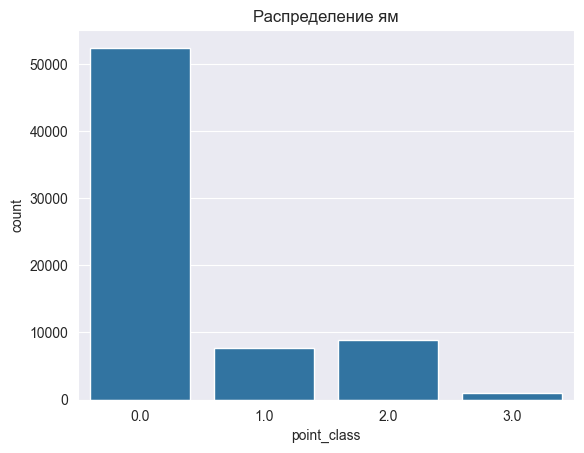

In [13]:
sns.countplot(x='point_class', data=data)
plt.title("Распределение ям")
plt.show()


классы распределены не равномерно, большой перекос у значения 0.
Получается нам необъодимо обучить модель классификации ям по телеметрическим данным автомобиля в условиях сильного дисбаланса классов.

In [36]:
target = 'point_class'
ignore_cols = ['point', 'point_class']
X = data.drop(columns=ignore_cols)
X = X.select_dtypes(include=[np.number]).copy()
y = data[target]
print(X.shape)
print(X.isna().sum().sum())
print(X.head())

X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna(axis=1, how='all')
X = X.fillna(X.mean())
y = y.loc[X.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

(70023, 22)
203541
   len  Скорость     Широта    Долгота  Высота  X Rotation  Y Rotation  \
0  0.0       6.0  60.646775  59.713850   338.0   82.961849   -0.870214   
1  1.0       6.0  60.646772  59.713873   339.7   79.659641   -4.668622   
2  3.0       6.0  60.646773  59.713905   339.2   80.631440   -6.564573   
3  4.0       7.0  60.646772  59.713928   339.4   84.225181   -1.929685   
4  6.0       7.0  60.646774  59.713966   337.7   80.798340   -1.001621   

   Вес мгновенный  Ускорение по оси X  Ускорение по оси Y  ...  \
0           104.0            0.015137            1.014160  ...   
1           105.0            0.086670            1.047607  ...   
2           102.0            0.118896            1.027954  ...   
3           103.0            0.035889            1.065308  ...   
4           104.0            0.016113            1.032471  ...   

   Расчетный выходной крутящий момент двигателя (в процентах от эталонного)  \
0                                                NaN        

Подготовили данные для обучения. 

Удалены целевые колонки: Из датасета исключены point (непрямая целевая) и point_class (основная целевая переменная), чтобы оставить только входные признаки (X). Выбраны только числовые признаки, используется select_dtypes(include=[np.number]), чтобы убрать категориальные и строковые данные. Применено StandardScaler, чтобы привести все числовые признаки к одному масштабу (среднее = 0, стандартное отклонение = 1).

In [56]:
y_clean = y.dropna()
y_clean = y_clean.astype(int)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_clean), y=y_clean)
weights = dict(zip(np.unique(y_clean), class_weights))

print(weights)


{np.int64(0): np.float64(0.33352720199843633), np.int64(1): np.float64(2.284548066875653), np.int64(2): np.float64(1.9796830786644029), np.int64(3): np.float64(16.98106796116505)}


Для задачи классификации с несбалансированными классами можно скорректировать веса классов. Приводим метки классов к целочисленному типу (int)
Вычисляем веса с помощью compute_class_weight() из sklearn

Для классификации ям было решено сравнить модели RandomForest и XGBoost, так как обе хорошо подходят для работы с табличными данными и способны учитывать особенности несбалансированных классов.

RandomForest —  ансамбль независимых деревьев решений, которые строятся на случайных подвыборках данных и признаков. Модель устойчива  к шуму и переобучению, а также не требует сложной настройки.

XGBoost реализует метод градиентного бустинга — последовательное обучение деревьев, каждое из которых исправляет ошибки предыдущих.

Такое сравнение моделей помогает оценить компромисс между простотой и скоростью обучения RandomForest и мощностью, но более сложной настройкой XGBoost.


In [ ]:
mask = y.notna()
X_clean = X_scaled[mask]
y_clean = y[mask].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
)

              precision    recall  f1-score   support

           0      0.961     0.860     0.907     10489
           1      0.505     0.762     0.607      1531
           2      0.792     0.926     0.854      1767
           3      0.882     0.981     0.929       206

    accuracy                          0.859     13993
   macro avg      0.785     0.882     0.824     13993
weighted avg      0.888     0.859     0.868     13993



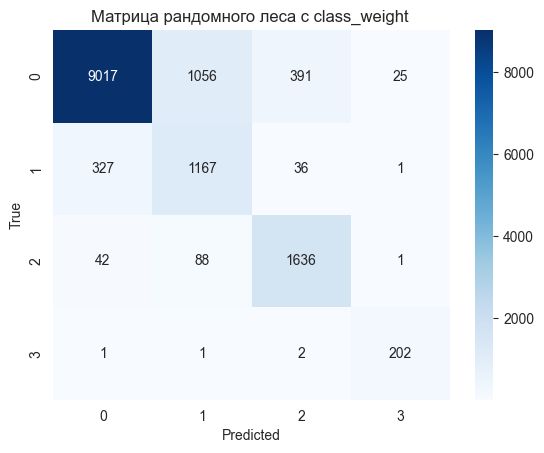

In [71]:

model = RandomForestClassifier(
    n_estimators=300,          # больше деревьев для лучшей стабильности
    max_depth=15,              # ограничиваем глубину, чтобы снизить переобучение
    min_samples_split=10,      # минимальное число объектов для разбиения узла
    min_samples_leaf=5,        # минимальное число объектов в листе
    max_features='sqrt',       # использовать корень из количества признаков на каждом разбиении
     class_weight=weights,  # учёт дисбаланса классов
    n_jobs=-1,                 # использовать все ядра процессора
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Матрица рандомного леса с class_weight ")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Модель с использованием class_weight показала более хорошее качество распознавания редких классов, по сравнению с моделью без учета весов. Recall для этих классов вырос, что означает, что модель стала лучше выявлять ямы и реже пропускает их. Однако на матрице мы видим, что диагональ не выстраивается и количество ложной классификации для класса 1 велико. 

              precision    recall  f1-score   support

           0      0.894     0.978     0.934     10489
           1      0.835     0.364     0.508      1531
           2      0.861     0.832     0.846      1767
           3      0.986     0.680     0.805       206

    accuracy                          0.888     13993
   macro avg      0.894     0.713     0.773     13993
weighted avg      0.884     0.888     0.874     13993



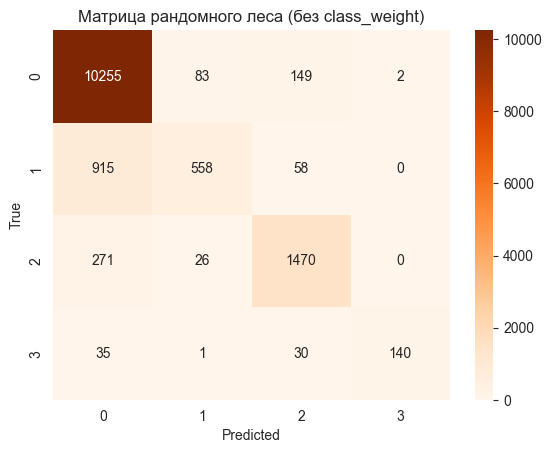

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model_no_weights = RandomForestClassifier(
    n_estimators=300,          # больше деревьев для лучшей стабильности
    max_depth=15,              # ограничиваем глубину, чтобы снизить переобучение
    min_samples_split=10,      # минимальное число объектов для разбиения узла
    min_samples_leaf=5,        # минимальное число объектов в листе
    max_features='sqrt',       # использовать корень из количества признаков на каждом разбиении
          # учёт дисбаланса классов
    n_jobs=-1,                 # использовать все ядра процессора
    random_state=42
)
model_no_weights.fit(X_train, y_train)


y_pred_no_weights = model_no_weights.predict(X_test)

print(classification_report(y_test, y_pred_no_weights, digits=3))

sns.heatmap(confusion_matrix(y_test, y_pred_no_weights), annot=True, fmt='d', cmap='Oranges')
plt.title("Матрица рандомного леса (без class_weight)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Без корректировки весов модель демонстрирует очень высокую точность на основном классе 0, однако recall для минорных классов значительно падает. Это приводит к тому, что ямы 1 и 3 классов почти игнорируются, что неприемлемо для задачи обнаружения повреждений дороги.

In [65]:
classes = np.unique(y_clean)
weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_clean)
class_weights = dict(zip(classes, weights_array))


max_weight = 7.0
class_weights = {cls: min(w, max_weight) for cls, w in class_weights.items()}
sample_weights = np.array([class_weights[label] for label in y_clean])

              precision    recall  f1-score   support

           0      0.960     0.914     0.936     10489
           1      0.612     0.767     0.681      1531
           2      0.903     0.964     0.932      1767
           3      0.961     0.947     0.954       206

    accuracy                          0.904     13993
   macro avg      0.859     0.898     0.876     13993
weighted avg      0.915     0.904     0.908     13993



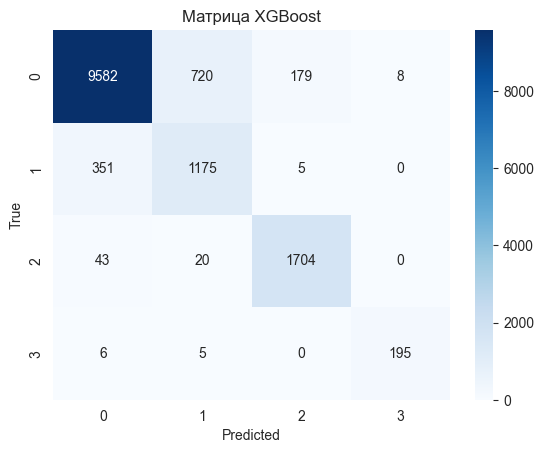

In [73]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X_clean,
    y_clean.astype(int),
    sample_weights,
    test_size=0.2,
    stratify=y_clean,
    random_state=42
)


xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=10,
    reg_alpha=0.1,        # L1-регуляризация
    reg_lambda=1.0,       # L2-регуляризация
    random_state=42
)


xgb_model.fit(X_train, y_train, sample_weight=sw_train)

y_pred_xgb = xgb_model.predict(X_test)


print(classification_report(y_test, y_pred_xgb, digits=3))


sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Матрица XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Модель XGBoost демонстрирует хорошее качество классификации на всех классах, особенно улучшая результаты по сравнению с RandomForest. Для класса 1 XGBoost показывает более сбалансированные показатели (precision 0.61 и recall 0.77). Общая точность модели составляет около 90%, XGBoost более эффективно справляется с дисбалансом.

 Вывод

- **RandomForest без учета весов** показал хорошую общую точность, но хуже справлялся с минорными классами (особенно с классом 1).
- **RandomForest с class_weight** улучшил recall для редких классов, но мог пожертвовать точностью для класса 0.
- **XGBoost с sample_weight** показал наилучший баланс между точностью и полнотой по всем классам:

По итогу работы и анализа лучше использовать XGBoost с sample_weight в качестве основной модели для задачи классификации ямы.